# Shapefile manipulation and geocoding

This notebook illustrates how to use the shapefile that is provided with the NYC metadata in python.
Specifically, it illustrates:
- Loading the shapefile using geopandas (*note*: GeoPandas is **not** installed by default. If you use anaconda, you can install it by simply running `conda install geopandas`. If you are not using anaconda, see [http://geopandas.org/] for installation instructions.
- Plotting GeoDataFrames, in particular the shapefile
- Mapping a (longitude, latitude) coordinate to a NYC taxi zone ID

**Note: this notebook assumes that**:
- the sampled data is in `data/sampled/` folder
- you ran the `download_metadata.sh` script to download the NYC metadata descriptions into the `metadata` subfolder

In [1]:
import os
import glob
import pandas as pd
import math
import numpy as np

## Loading trip data with longitude/lattitude data

In [2]:
df1 = pd.read_csv('data/sampled/yellow_tripdata_2016-06.csv')
df1.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-06-09 21:06:36,2016-06-09 21:35:11,1,5.22,-73.981720,40.736668,1,N,-73.981636,40.670242,1,22.0,0.5,0.5,4.00,0.0,0.3,27.30
1,2,2016-06-09 21:09:51,2016-06-09 21:30:57,1,2.21,-73.981628,40.763710,1,N,-74.004112,40.742130,1,14.5,0.5,0.5,3.16,0.0,0.3,18.96
2,1,2016-06-09 21:09:56,2016-06-09 21:23:26,1,3.70,-73.953995,40.774841,1,N,-73.996407,40.765015,1,13.5,0.5,0.5,1.00,0.0,0.3,15.80
3,2,2016-06-09 21:09:56,2016-06-09 21:19:50,3,1.90,-74.007309,40.715786,1,N,-73.986580,40.731285,2,8.5,0.5,0.5,0.00,0.0,0.3,9.80
4,1,2016-06-09 21:13:24,2016-06-09 21:18:32,1,0.60,-74.000130,40.734825,1,N,-73.991425,40.735016,2,5.0,0.5,0.5,0.00,0.0,0.3,6.30


In [3]:
df1.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

As you can see, this particular datafile contains (longitude, latitude) information for both the trip's pickup and dropoff

## Geopandas: loading the shapefile and plotting it

In [4]:
import matplotlib.pyplot as plt 
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [5]:
# Load the shapefile, this yields a GeoDataFrame that has a row for each zone
zones = gpd.read_file('metadata/taxi_zones/taxi_zones.shp')
zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."


Note in particular the "geometry" column. This contains the shape (specified as a geometry) that defines the complete taxi zone.  Note that "Polygon", "Multipologon" etc, are defined in the shapely library.

The LocationID corresponds to the zone ID, as specified in the `taxi+_zone_lookup.csv` metadata file, and the borough and zone name also correspond to the information stored in that file.

In [6]:
type(zones)

geopandas.geodataframe.GeoDataFrame

Geopandas makes it super-easy to visualize geographic data, as shown next.

In [7]:
# Make sure that all matplot lib objects are drawn inline in the jupyter notebook
%matplotlib inline

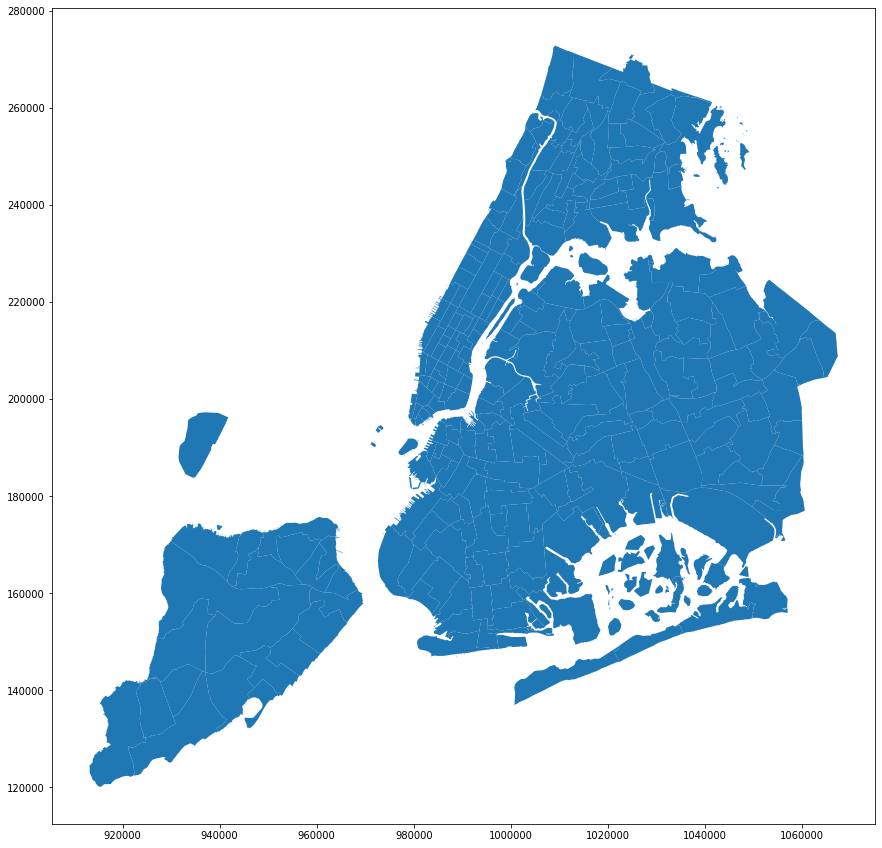

In [8]:
# Plot the shapefile using geopandaspoint = subdf
fig,ax = plt.subplots(figsize=(15,15))
zones.plot(ax=ax)

## Checking whether a point is in a specific geometry

Any Geometry object (a polygon, a point, a multipologyn,...) in shapely has a `contains` method that allows us to check whether another geometry is completely contained in it. 

In [9]:
# Get the first zone
z0 = zones.iloc[0]
z0

OBJECTID                                                      1
Shape_Leng                                             0.116357
Shape_Area                                          0.000782307
zone                                             Newark Airport
LocationID                                                    1
borough                                                     EWR
geometry      POLYGON ((933100.9183527103 192536.0856972019,...
Name: 0, dtype: object

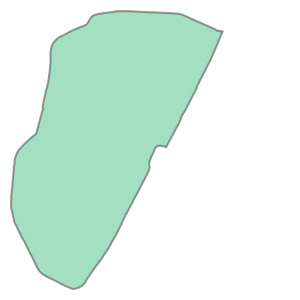

In [10]:
z0.geometry

In [11]:
z0.geometry.contains( Point(933100.9183527103, 192536.0856972019))

True

In [12]:
z0.geometry.contains( Point(923100.9183527103, 182536.0856972019))

False

All geographic data (points, geometries, etc) are defined with respect to some Coordinate Reference System (henceforth: CRS). Basically, the CRS specifies how a specific coordinate should be interpreted. Note that all geometry in the `zones` geodataframe are specified w.r.t. the EPSG 2263 CRS (https://epsg.io/2263). This is a CRS that is specifically designed to describe new york long island.

In [13]:
# Let's inspect the taxi zones CRS
zones.crs

{'init': 'epsg:2263'}

If we want to determine whether a (longitude, latitude) point specified in the GPS coordinate system falls within one of the NYC taxi zones, we will need to convert the `zones` geodataframe so that it references the GPS coordinate system. The following line illustrates the problem when we use the current (long-island) CRS.

In [26]:
# Let's try and find the zone that contains the pickup location of our first trip
query_point = Point( df1.iloc[0].pickup_longitude, df1.iloc[0].pickup_latitude)

In [15]:
for index, tup in zones.iterrows():
    if tup.geometry.contains(query_point):
        print("LocationID=%d, borough=%s, zone=%s" % (tup.LocationID, tup.borough, tup.zone))

^^^ Note that the output was empty: no such zone was found (because the zone's geometry and the query point are specified in different coordinate systems). We can solve this problem by re-projecting the zone dataframe on the GPS coordinate system (EPSG:4326)

In [16]:
# Now re-project the coordinates to the CRS EPSG 4326, which is the CRS used in GPS (https://epsg.io/4326)
zones = zones.to_crs({'init':'epsg:4326'})
zones

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((-73.85107 40.91037, -73.85207 40.909..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((-73.90175 40.76078, -73.90147 40.759..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((-74.01333 40.70503, -74.01327 40.704..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ..."


In [17]:
# Now let's find the zone of our first trip's pickup point.
for index, tup in zones.iterrows():
    if tup.geometry.contains(query_point):
        print("LocationID=%d, borough=%s, zone=%s" % (tup.LocationID, tup.borough, tup.zone))

LocationID=107, borough=Manhattan, zone=Gramercy


^^^ This time it is found!

To convince ourselves that we are really finding the pickup locations, let's plot them together on a map.

In [18]:
# Create a sub-dataframe of 10 points that we will plot
subdf = df1[0:9]
subdf

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-06-09 21:06:36,2016-06-09 21:35:11,1,5.22,-73.981720,40.736668,1,N,-73.981636,40.670242,1,22.0,0.5,0.5,4.00,0.0,0.3,27.30
1,2,2016-06-09 21:09:51,2016-06-09 21:30:57,1,2.21,-73.981628,40.763710,1,N,-74.004112,40.742130,1,14.5,0.5,0.5,3.16,0.0,0.3,18.96
2,1,2016-06-09 21:09:56,2016-06-09 21:23:26,1,3.70,-73.953995,40.774841,1,N,-73.996407,40.765015,1,13.5,0.5,0.5,1.00,0.0,0.3,15.80
3,2,2016-06-09 21:09:56,2016-06-09 21:19:50,3,1.90,-74.007309,40.715786,1,N,-73.986580,40.731285,2,8.5,0.5,0.5,0.00,0.0,0.3,9.80
4,1,2016-06-09 21:13:24,2016-06-09 21:18:32,1,0.60,-74.000130,40.734825,1,N,-73.991425,40.735016,2,5.0,0.5,0.5,0.00,0.0,0.3,6.30
5,2,2016-06-09 21:06:00,2016-06-09 21:14:23,2,1.15,-74.006660,40.738770,1,N,-73.991867,40.745098,1,7.0,0.5,0.5,1.66,0.0,0.3,9.96
6,1,2016-06-09 21:06:41,2016-06-09 21:24:21,1,4.40,-74.009445,40.710701,1,N,-73.993591,40.759682,1,16.5,0.5,0.5,3.55,0.0,0.3,21.35
7,1,2016-06-09 21:06:43,2016-06-09 21:13:36,1,0.60,-73.979416,40.746330,1,N,-73.988342,40.743446,1,6.0,0.5,0.5,1.45,0.0,0.3,8.75
8,1,2016-06-09 21:06:46,2016-06-09 21:19:13,1,2.50,-73.955750,40.764252,1,N,-73.980164,40.738861,1,11.5,0.5,0.5,2.00,0.0,0.3,14.80


In [19]:
# Turn this subdf into a GeoDF, adding a "geometry" column to pinpoint the pickup location
geometry = [Point(xy) for xy in zip(subdf['pickup_longitude'], subdf['pickup_latitude'])]
geo_subdf = gpd.GeoDataFrame(subdf, geometry=geometry)
geo_subdf

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,geometry
0,2,2016-06-09 21:06:36,2016-06-09 21:35:11,1,5.22,-73.981720,40.736668,1,N,-73.981636,40.670242,1,22.0,0.5,0.5,4.00,0.0,0.3,27.30,POINT (-73.98172 40.73667)
1,2,2016-06-09 21:09:51,2016-06-09 21:30:57,1,2.21,-73.981628,40.763710,1,N,-74.004112,40.742130,1,14.5,0.5,0.5,3.16,0.0,0.3,18.96,POINT (-73.98163 40.76371)
2,1,2016-06-09 21:09:56,2016-06-09 21:23:26,1,3.70,-73.953995,40.774841,1,N,-73.996407,40.765015,1,13.5,0.5,0.5,1.00,0.0,0.3,15.80,POINT (-73.95399 40.77484)
3,2,2016-06-09 21:09:56,2016-06-09 21:19:50,3,1.90,-74.007309,40.715786,1,N,-73.986580,40.731285,2,8.5,0.5,0.5,0.00,0.0,0.3,9.80,POINT (-74.00731 40.71579)
4,1,2016-06-09 21:13:24,2016-06-09 21:18:32,1,0.60,-74.000130,40.734825,1,N,-73.991425,40.735016,2,5.0,0.5,0.5,0.00,0.0,0.3,6.30,POINT (-74.00013 40.73483)
5,2,2016-06-09 21:06:00,2016-06-09 21:14:23,2,1.15,-74.006660,40.738770,1,N,-73.991867,40.745098,1,7.0,0.5,0.5,1.66,0.0,0.3,9.96,POINT (-74.00666 40.73877)
6,1,2016-06-09 21:06:41,2016-06-09 21:24:21,1,4.40,-74.009445,40.710701,1,N,-73.993591,40.759682,1,16.5,0.5,0.5,3.55,0.0,0.3,21.35,POINT (-74.00945 40.71070)
7,1,2016-06-09 21:06:43,2016-06-09 21:13:36,1,0.60,-73.979416,40.746330,1,N,-73.988342,40.743446,1,6.0,0.5,0.5,1.45,0.0,0.3,8.75,POINT (-73.97942 40.74633)
8,1,2016-06-09 21:06:46,2016-06-09 21:19:13,1,2.50,-73.955750,40.764252,1,N,-73.980164,40.738861,1,11.5,0.5,0.5,2.00,0.0,0.3,14.80,POINT (-73.95575 40.76425)


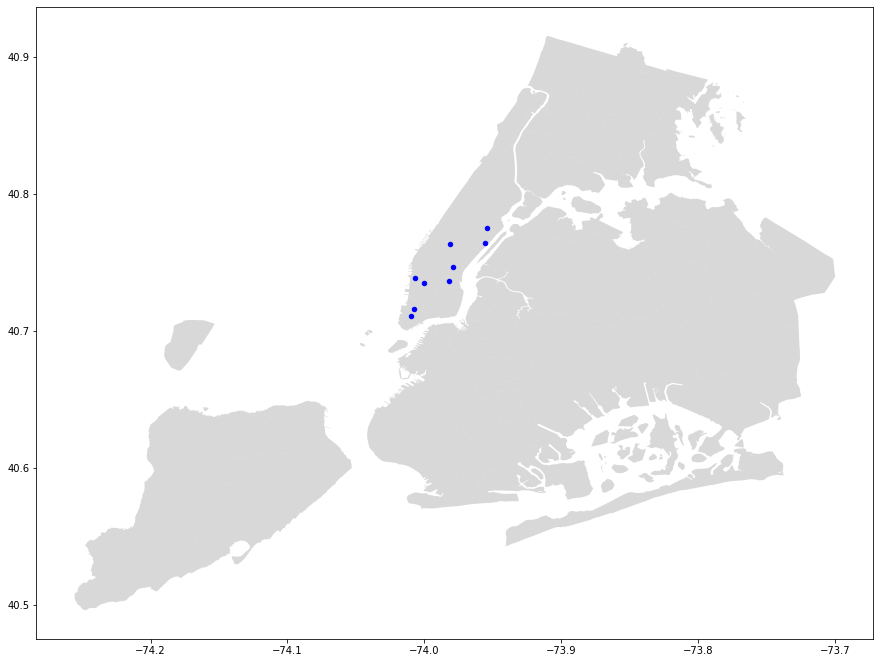

In [20]:
fig,ax = plt.subplots(figsize=(15,15))
zones.plot(ax=ax, alpha=0.3, color="grey")
geo_subdf.plot(ax=ax, markersize=20, color="blue", marker="o")

## Fast reverse geocoding

The process of, given (long, lat), finding the "area" (in our case: zone) in which this point occurs is known as **reverse geocoding**. If you need to do this for a large number of points, it helps to first build a special kind of index on the zones. This index will allow each corresponding zone to be found quickly (i.e., without needing to make a linear scan through the zones).

In [21]:
# A geopanda dataframe has the possibility to create an R-tree index on it's geometry
rtree = zones.sindex

In [27]:
# By means of the intersection() method we can query for all the entries in the zones dataframe that 
# *can* intersect with a query point
# Note: this mentod can return false positives; the actual zone is part of the result.
# The method returns a generator. We use the list(.) constructor to convert this to a list.

query_point = Point( df1.iloc[0].pickup_longitude, df1.iloc[0].pickup_latitude)
possible_matches = list(rtree.intersection( query_point.bounds ))
possible_matches

[223, 106, 136]

In [23]:
zones.iloc[ possible_matches ]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
223,224,0.044020,0.000098,Stuy Town/Peter Cooper Village,224,Manhattan,"POLYGON ((-73.97511 40.73539, -73.97496 40.735..."
106,107,0.038041,0.000075,Gramercy,107,Manhattan,"POLYGON ((-73.98239 40.73141, -73.98256 40.731..."
136,137,0.046108,0.000116,Kips Bay,137,Manhattan,"POLYGON ((-73.97220 40.74040, -73.97222 40.740..."


Note that among the candiate matches, only one will actually match:

In [28]:
zones.iloc[223].geometry.contains( query_point )

False

In [29]:
zones.iloc[106].geometry.contains( query_point )

True

In [30]:
zones.iloc[136].geometry.contains( query_point )

False

# Packaging this up in a function
Now integrate all of what you have learned above into a single piece of code, that you can re-use when solving the data integration task.

In [31]:
# Your answer goes here